<a href="https://colab.research.google.com/github/Ehtisham1053/Classification-ML-algorithms/blob/main/Random_forest_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Manual implementation without using the sklearn class

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [3]:
class ManualRandomForest:
    def __init__(self, n_estimators=10, sample_size=0.8, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.max_depth = max_depth
        self.max_features = max_features
        self.models = []
        self.subsets = []

    def fit(self, X, y):
        self.models = []
        self.subsets = []
        n_samples = int(self.sample_size * len(X))
        n_features = self.max_features if self.max_features else X.shape[1]

        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), n_samples, replace=True)
            feature_indices = np.random.choice(X.shape[1], n_features, replace=False)
            X_subset, y_subset = X[indices][:, feature_indices], y[indices]

            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(X_subset, y_subset)
            self.models.append((model, feature_indices))
            self.subsets.append(indices)

    def predict(self, X):
        predictions = np.zeros((self.n_estimators, len(X)))
        for i, (model, feature_indices) in enumerate(self.models):
            predictions[i] = model.predict(X[:, feature_indices])

        # Majority voting for classification
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
        return final_predictions

    def evaluate(self, X_train, y_train, X_test, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        report = classification_report(y_test, y_test_pred)

        print("Training Accuracy:", train_acc)
        print("Testing Accuracy:", test_acc)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", report)

        # return train_acc, test_acc, cm, report

In [5]:
data = sns.load_dataset("penguins").dropna()
X = data.drop(columns=['species']).select_dtypes(include=[np.number]).values
y = data['species'].astype('category').cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train and Evaluate Manual Random Forest
manual_rf = ManualRandomForest(n_estimators=5, sample_size=0.8, max_depth=3, max_features=2)
manual_rf.fit(X_train, y_train)
manual_rf.evaluate(X_train, y_train, X_test, y_test)

Training Accuracy: 0.8872180451127819
Testing Accuracy: 0.8805970149253731
Confusion Matrix:
 [[31  0  0]
 [ 7  6  0]
 [ 1  0 22]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89        31
           1       1.00      0.46      0.63        13
           2       1.00      0.96      0.98        23

    accuracy                           0.88        67
   macro avg       0.93      0.81      0.83        67
weighted avg       0.91      0.88      0.87        67



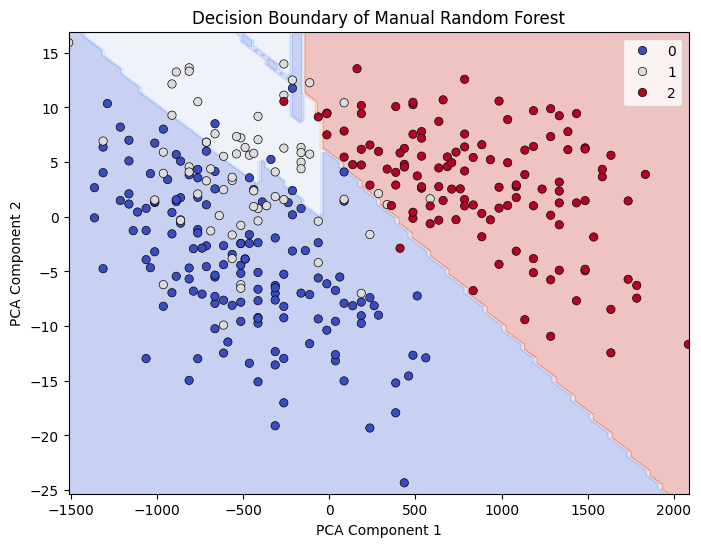

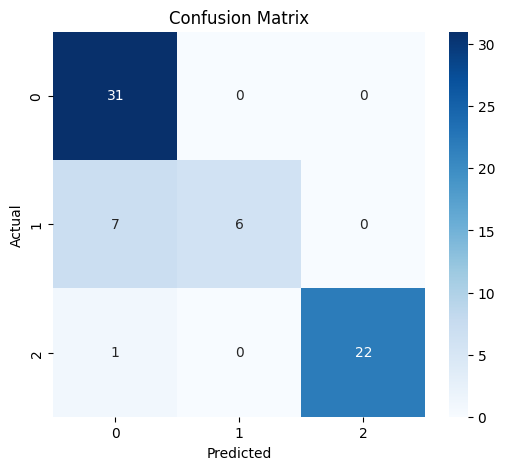

In [8]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_pca = pca.transform(X)

xx, yy = np.meshgrid(np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 100),
                     np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 100))
Z = manual_rf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Boundary of Manual Random Forest")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, manual_rf.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
